# Методы обработки и распознавания изображений¶

## Свертка изображений

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Учимся работать с картинками средствами **Python**, **NumPy** и **PyTorch**

### Загружаем изображение с диска

Image format: JPEG; shape: (625, 350); color scheme: RGB


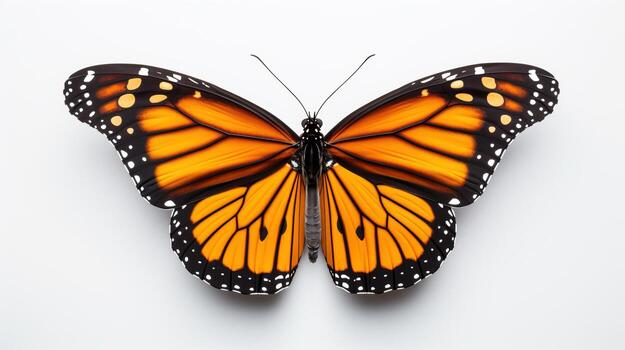

In [2]:
# !pip install Pillow
from PIL import Image

img = Image.open("butterfly.jpg") #Используйте любое изображение
print(f"Image format: {img.format}; shape: {img.size}; color scheme: {img.mode}")
img

### Матричное представление изображения

Мы знаем, что цветное изображение состоит из 3 числовых матриц или трехмерного тензора. Каждая матрица соответствует одному из 3 базовых цветов: красному, зеленому и синему.

Image array shape: (350, 625, 3)


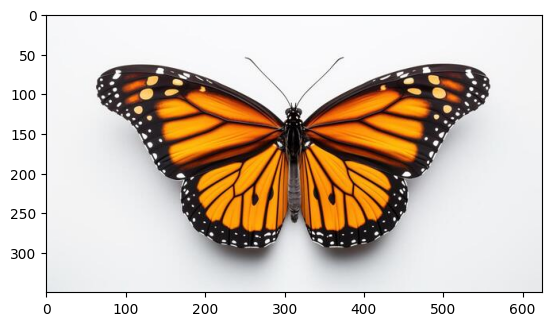

In [3]:
# преобразуем изображение в массив
img_matrix = np.array(img)

# (высота, ширина, число каналов)
print(f"Image array shape: {img_matrix.shape}")

plt.imshow(img_matrix)
plt.show()

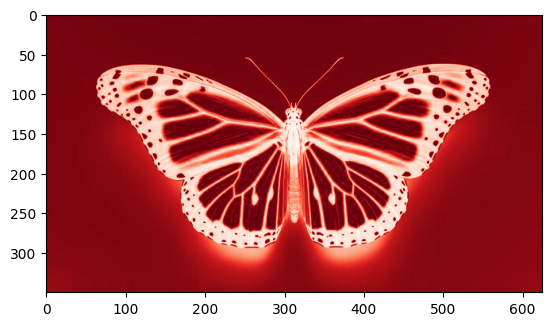

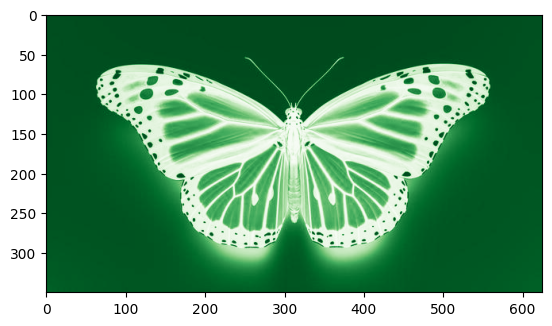

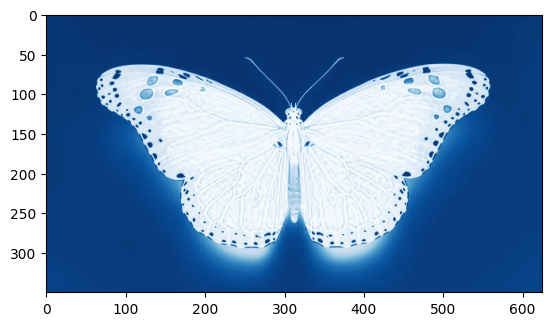

In [4]:
# посмотрим на все каналы изображения отдельно
plt.imshow(img_matrix[:, :, 0], cmap=cm.Reds)
plt.show()

plt.imshow(img_matrix[:, :, 1], cmap=cm.Greens)
plt.show()

plt.imshow(img_matrix[:, :, 2], cmap=cm.Blues)
plt.show()

## 2. Применяем константные свёртки к изображениям

### Класс torch.nn.Conv2d
В **PyTorch** свёрточный слой представлен в модуле `torch.nn` классом [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) с параметрами:
- количество входных каналов `in_channels`
- количество выходных каналов `out_channels`
- размер ядра `kernel_size`
- шаг `stride`
- паддинг `padding`
- режим паддинга `padding_mode` (`'zeros'`, `'reflect'` и др.)
- растяжение `dilation`

___
**Размер ядра** - `int`, если ядро квадратное и кортеж из двух чисел, если ядро прямоугольное. Задает размер фильтра, с которым производится свёртка изображения.

**kernel_size=3**



___
**Шаг** - задает шаг, в пикселях, на который сдвигается фильтр. `int`, если по горизонтали и вертикали сдвигается на одно и то же число. Кортеж из двух чисел, если сдвиги разные.

**stride=2**



___
**Паддинг** - количество пикселей, которыми дополняется изображение. Аналогично шагу и размеру ядра, может быть, как `int`, так и кортежем из двух чисел.

**padding="half"**


### Свёртка изображений
Применим оператор Собеля для детектирования границ на изображении. Для этого пока не будем пользоваться классом `torch.nn.Conv2d`, а возьмём соответствующую функцию из модуля `torch.nn.functional`. В этом модуле примерно все те же самые операторы, что и в `torch.nn`, но только представлениы они не в виде классов, а виде функций.

In [5]:
import torch
from torch.nn.functional import conv2d

Конвертируем изображение в тензор и переставим размерности в порядке `(batch_size, n_channels, height, width)`, который принят в **PyTorch**.

In [6]:
img_matrix.shape

(350, 625, 3)

In [7]:
img_tensor = torch.tensor(img_matrix, dtype=torch.float)
img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
img_tensor.size()

torch.Size([1, 3, 350, 625])

Зададим оператор Собеля для детектирования горизонтальных границ

In [8]:
sobel_hor = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

# одна матрица на каждый канал картинки
kernel = [[sobel_hor, sobel_hor, sobel_hor]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size()

torch.Size([1, 3, 3, 3])

In [9]:
# свернём картинку с подготовленным ядром свёртки
img_conv_hor = conv2d(img_tensor, kernel)
img_conv_hor = img_conv_hor.permute(0, 2, 3, 1)
img_conv_hor.size()

torch.Size([1, 348, 623, 1])

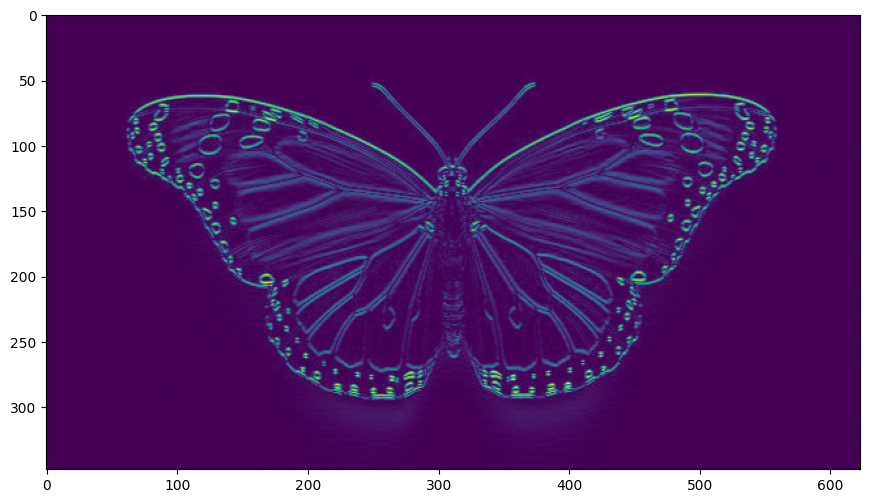

In [13]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]))
plt.show()

Проделаем то же самое для детектирования вертикальных границ

In [14]:
sobel_ver = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]

# одна матрица на каждый канал картинки
kernel = [[sobel_ver, sobel_ver, sobel_ver]]
kernel = torch.tensor(kernel, dtype=torch.float)

img_conv_ver = conv2d(img_tensor, kernel)

img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)
img_conv_ver.size()

torch.Size([1, 348, 623, 1])

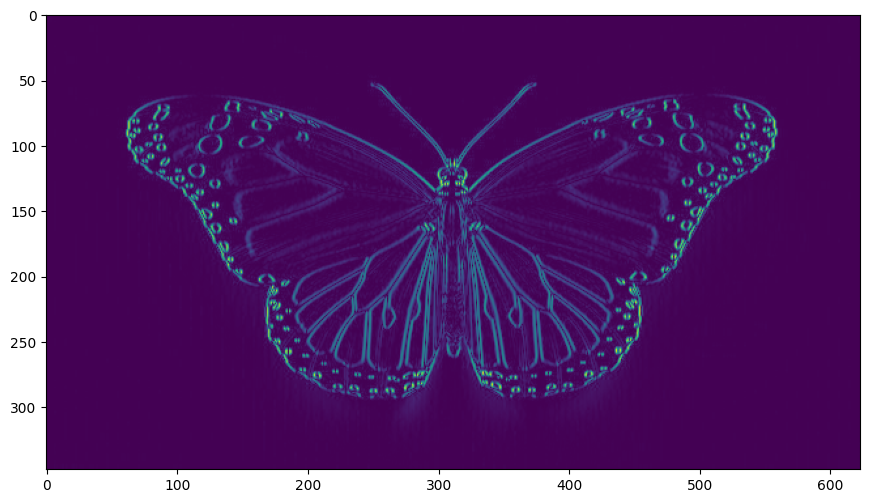

In [15]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

Объединим два изображения

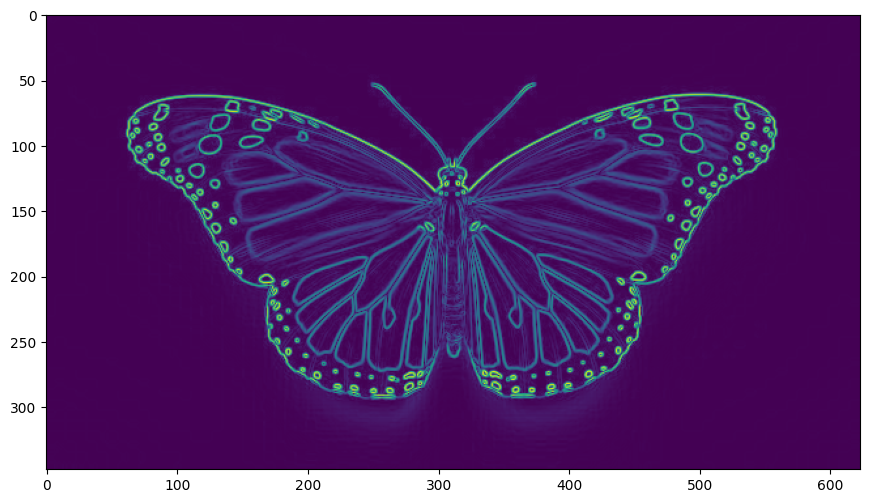

In [16]:
img_conv = torch.sqrt(img_conv_ver**2 + img_conv_hor**2)

plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(img_conv[0, :, :, 0])
plt.show()

### Задание 1
По аналогии с примером выше, сверните изображение со случайным ядром такого же размера.

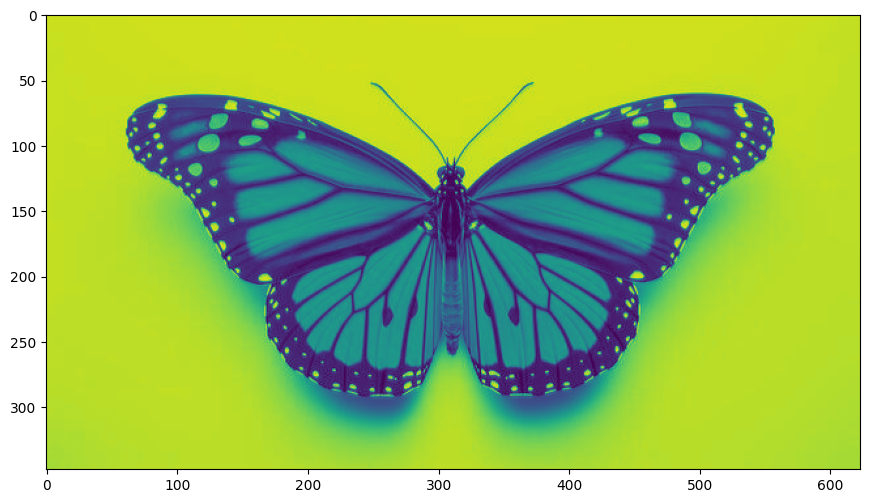

In [31]:
### MY CODE HERE
my_operator = [[1, 2, 12], [2, 0, 2], [1, -15, 123]]
kernel = [[my_operator, my_operator, my_operator]]
kernel = torch.tensor(kernel, dtype=torch.float)
img_conv_new = conv2d(img_tensor, kernel)
img_conv_new = img_conv_new.permute(0, 2, 3, 1)

# рисуем результат
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_new[0, :, :, 0]))
plt.show()

### Сравниваем работу полносвязных и свёрточных сетей на датасете MNIST

Сначала решим задачу классификации изображений полносвязной нейронной сетью из прошлого семинара.

In [19]:
import torch.nn.functional as F
import torchvision
from torch import nn

Скачаем и подготовим уже знакомые нам данные для классификации.

In [20]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=transform
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=transform
)


train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=False)

Подготовим цикл обучения.

In [21]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):
        # тренировка
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend(
                        (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
                    )

            # печатаем метрики
            print(
                f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}"
            )

Обучим полносвязную архитектуру.

In [22]:
model = nn.Sequential(
    nn.Flatten(),  # превращаем картинку 28х28 в вектор размером 784
    nn.Linear(
        28 * 28, 128
    ),  # линейный слой, преобразующий вектор размера 784 в вектор размера 128
    nn.ReLU(),  # нелинейность
    nn.Linear(
        128, 10
    ),  # линейный слой, преобразующий вектор размера 128 в вектор размера 10
)

optimizer = torch.optim.SGD(
    model.parameters(), lr=0.01
)  # создаем оптимизатор и передаем туда параметры модели

In [23]:
print(
    f"Training model with {sum([x[1].numel() for x in model.named_parameters()])} parameters"
)
train(model, optimizer)

Training model with 101770 parameters


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.31630876660346985, accuracy: 0.912


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.22714106738567352, accuracy: 0.935


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.18262635171413422, accuracy: 0.9463


Изменим архитектуру, добавив в неё свёрточные слои.

In [24]:
model = nn.Sequential(
    nn.Conv2d(
        in_channels=1, out_channels=10, kernel_size=5
    ),  # добавим свёрточный слой с 10 ядрами
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),  # уменьшим картинку в 4 раза по каждой стороне
    nn.Flatten(),  # превращаем картинку 6х6х10 в вектор размером 360
    nn.Linear(
        6 * 6 * 10, 128
    ),  # линейный слой, преобразующий вектор размера 360 в вектор размера 128
    nn.ReLU(),  # нелинейность
    nn.Linear(
        128, 10
    ),  # отображение в пространство размерности числа меток классификации
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [25]:
print(
    f"Training model with {sum([x[1].numel() for x in model.named_parameters()])} parameters"
)
train(model, optimizer)

Training model with 47758 parameters


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.2189028263092041, accuracy: 0.9376


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.11242841929197311, accuracy: 0.9667


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.07996600866317749, accuracy: 0.974


### Задание 2

По аналогии с предыдущим примером, обучите нейронную сеть, у которой будут следующие слои:

- Свёрточный слой с 10 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Свёрточный слой с 20 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Полносвязный слой со 128 нейронами
- Функция активации ReLU
- Выходной слой

Сделайте решение с моделью в виде класса, отнаследованного от `torch.nn.Module`.

In [26]:
### MY CODE HERE
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.fc1 = nn.Linear(6*6*20, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # 24*24*10
        x = F.max_pool2d(x, 2)  # 12*12*10
        x = F.relu(self.conv2(x)) # 8*8*20
        x = F.max_pool2d(x, 2) # 4*4*20
        x = x.view(-1, 4*4*20) # альтернатива Flatten()
        x = F.relu(self.fc1(x))
        return x.relu(self.fc2(x))


optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [27]:
train(model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.07070639729499817, accuracy: 0.9772


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.06243089213967323, accuracy: 0.9801


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.04863570258021355, accuracy: 0.9844
